In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.3 MB/s 
     |████████████████████████████████| 365 kB 28.5 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
     |████████████████████████████████| 120 kB 73.8 MB/s 
     |████████████████████████████████| 212 kB 57.7 MB/s 
     |████████████████████████████████| 115 kB 28.4 MB/s 
     |████████████████████████████████| 127 kB 51.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import os
import torch
import pandas as pd
import numpy as np
from datasets import load_metric
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from google.colab import drive

drive.mount('./drive')

Mounted at ./drive


In [4]:
df_train = pd.read_csv('/content/h2i_01_asset_type_train_v1.csv')
df_valid = pd.read_csv('/content/h2i_01_asset_type_valid_v1.csv')
df_test = pd.read_csv('/content/h2i_01_asset_type_test_v1.csv')

In [5]:
num_labels = len(df_train.label.unique())
df_train.head()

,Unnamed: 0,text,label
0,2428,Как инвестировать в недвижимость подскажи,0
1,3283,можно мне вложиться в инвестиции,1
2,1074,Инвестиции в золото это будет лучше инвестиции,0
3,2490,Скажи мне вот меня интересует вопрос инвестици...,0
4,366,Во что инвестирует чаще всего?,1


In [ ]:
model_checkpoint = 'DeepPavlov/rubert-base-cased-conversational'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-conversational', 
                                                           num_labels=num_labels)
if device == 'cuda':
  model.to(device);

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassi

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 0. Обучим базовую модель на наших данных, глянем метрики и количество параметров в основных слоях

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_texts, labels, device=device):
      self.tokenized_texts = tokenized_texts
      self.labels = labels
      self.device = device

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]).to(self.device) for key, val in self.tokenized_texts.items()}
      item['labels'] = torch.tensor(self.labels[idx]).to(self.device)
      return item

In [7]:

train_tokenized_dataset = tokenizer(list(df_train['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)
valid_tokenized_dataset = tokenizer(list(df_valid['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)
test_tokenized_dataset = tokenizer(list(df_test['text'].values), padding="max_length", 
                              truncation=True, return_tensors='pt', max_length = 512)

train_dataset = CustomDataset(train_tokenized_dataset, df_train['label'])
valid_dataset = CustomDataset(valid_tokenized_dataset, df_valid['label'])
test_dataset = CustomDataset(test_tokenized_dataset, df_test['label'])

NameError: ignored

In [ ]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=2,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    save_total_limit=1,            # limit the total amount of checkpoints. Deletes the older checkpoints.    
    dataloader_pin_memory=False     # If true issue error while train
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2602
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1630
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.209800,0.960000
2,0.256000,0.154387,0.965714


***** Running Evaluation *****
  Num examples = 350
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 350
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/ipykern

KeyboardInterrupt: ignored

## Num of params

In [ ]:
total_params_embeddings = sum(
	param.numel() for param in model.bert.embeddings.parameters()
)

total_params_encoder = sum(
	param.numel() for param in model.bert.encoder.parameters()
)


In [ ]:
print(f'Count of encoder parameters: {total_params_encoder}')
print(f'Count of embeddings parameters: {total_params_embeddings}')

encoder + embedding ~ 98% of all params

## Get metrics of model

In [ ]:
predicted_labels = []
true_labels = []
for sample in test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)#.to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0)#.to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0)#.to('cpu')
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

## Inference time on CPU/GPU

In [ ]:
# GPU Inference time.
%%timeit
c=0
for sample in test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c+=1

In [ ]:
model.to('cpu');

In [ ]:
# CPU Inference time.
%%timeit
c_cpu=0
for sample in test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0).to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0).to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0).to('cpu')
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c_cpu+=1
  if c_cpu % 100 == 0:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


2min 31s ± 1.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# true_positive = sum([1 if pred == true_label else 0 for pred, true_label in zip(predicted_labels, true_labels)])
# accuracy = true_positive/len(true_labels)
test_score = f1_score(true_labels, predicted_labels)
print(f'f1_score: {test_score}')
print(f'Inference time on GPU: {12.6/len(test_dataset)} seconds')
print(f'Inference time on CPU: {151/100} seconds')

f1_score: 0.9667673716012085
Inference time on GPU: 0.036 seconds
Inference time on CPU: 1.51 seconds


## Model save

In [ ]:
model_save_dir = '/content/drive/MyDrive/models/finetuned_bert/'
torch.save(model.state_dict(), model_save_dir+'pytorch_model.bin')

# 1. Quantinization

## 1.1 Quantization Linear

Загружаю обученную на наших данных модель из гугл диска. Делаю это по той причине, что модель обучалась на GPU, и после квантизации модели не получится делать инференс, поскольку квантизированные слои пока поддерживают только CPU. Перекладка модели на CPU через pytorch не помогает, поэтому приходится загружать модель снова

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_save_dir);
tokenizer = AutoTokenizer.from_pretrained(model_save_dir);

In [ ]:
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

## Check the model size

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 711.502125
Size (MB): 454.981957


## Get metrics

In [ ]:
cpu_test_dataset = CustomDataset(test_tokenized_dataset, df_test['label'], 'cpu')

In [ ]:
predicted_labels = []
true_labels = []
for sample in cpu_test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = quantized_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
%%timeit
c=0
for sample in cpu_test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = quantized_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c+=1
  if c % 100 == 0:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


1min 58s ± 2.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(f'F1_score: {f1_score(true_labels, predicted_labels)}')
print(f'Inference time on CPU: {118/100}')

F1_score: 0.9667673716012085
Inference time on CPU: 1.18


## Save quantized model

In [ ]:
quantized_model_save_dir = '/content/drive/MyDrive/models/quantized_bert/'
torch.save(quantized_model.state_dict(), quantized_model_save_dir+'pytorch_model.bin')

## 1.2 Quantize linear + embedding layers

In [ ]:
model.to('cpu');

In [ ]:
from torch.quantization.qconfig import float_qparams_weight_only_qconfig, default_dynamic_qconfig

qconfig_dict = {
    torch.nn.Embedding : float_qparams_weight_only_qconfig,
    torch.nn.Linear: default_dynamic_qconfig
}
full_quantized_model = torch.quantization.quantize_dynamic(model, qconfig_dict)

In [ ]:
predicted_labels = []
true_labels = []
for sample in tqdm(cpu_test_dataset):
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = full_quantized_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
  9%|▉         | 33/350 [00:42<06:50,  1.30s/it]


KeyboardInterrupt: ignored

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(full_quantized_model)

Size (MB): 711.502125
Size (MB): 179.324089


In [ ]:
%%timeit
c=0
for sample in cpu_test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = full_quantized_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c+=1
  if c % 100 == 0:
    break

In [ ]:
print(f'F1_score: {f1_score(true_labels, predicted_labels)}')
print(f'Inference time on CPU: {113/100}')

F1_score: 0.9565217391304348
Inference time on CPU: 1.18


# 2. Matrix Decomposition

In [ ]:
!pip3 install tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 5.1 MB/s 
     |████████████████████████████████| 154 kB 71.3 MB/s 


In [ ]:
import tensorly
tensorly.set_backend('pytorch')
from tensorly.decomposition import tucker, partial_tucker
from tensorly.tenalg import mode_dot

## Tucker decomposition

In [ ]:
def tucker_decomposition_conv_layer(weight, bias, rank, device):
    """ Gets a conv layer, 
        returns a list of products of the Tucker decomposition.
    """

    
    core, [last, first] = \
        partial_tucker(weight.data, \
            modes=[0,1], rank=rank, init='svd')
    
    first_layer = torch.nn.Conv1d(in_channels=first.shape[0], \
            out_channels=first.shape[1], kernel_size=1)
    
    core_layer = torch.nn.Conv1d(in_channels=core.shape[1], \
            out_channels=core.shape[0], kernel_size=1)
    
    last_layer = torch.nn.Conv1d(in_channels=last.shape[1], \
        out_channels=last.shape[0], kernel_size=1)
    
    last_layer.bias.data = bias.data

    first_layer.weight.data = \
        torch.transpose(first, 1, 0).unsqueeze(-1)
    last_layer.weight.data = last.unsqueeze(-1)
    core_layer.weight.data = core

    new_layers = [first_layer.to(device), core_layer.to(device), last_layer.to(device)]
    return new_layers

In [ ]:
class TuckerLinear(torch.nn.Module):
    def __init__(self, fc_w, fc_b, rank):
        super().__init__()
        if fc_w.shape[0] == fc_w.shape[1]:
          self.first_layer, self.core_layer, self.last_layer = tucker_decomposition_conv_layer(torch.transpose(fc_w, 0, 1).unsqueeze(2), fc_b, rank = rank, device=device)
        else:
          self.first_layer, self.core_layer, self.last_layer = tucker_decomposition_conv_layer(fc_w.unsqueeze(2), fc_b, rank = rank, device=device)
        self.first_layer.to(device)
        self.core_layer.to(device)
        self.last_layer.to(device)

    def forward(self, x):
        x3 = self.first_layer(x.transpose(1, 2))
        x3 = self.core_layer(x3.transpose(2, 0))
        x3 = self.last_layer(x3.transpose(2, 0))
       
        
        return (x3.transpose(1, 2).contiguous())

In [ ]:
def get_predict(model):
  predicted_labels = []
  true_labels = []
  c = 0
  for sample in test_dataset:
    true_label = sample['labels']
    input_ids = sample['input_ids'].unsqueeze(0)
    attention_mask = sample['attention_mask'].unsqueeze(0)
    token_type_ids = sample['token_type_ids'].unsqueeze(0)
    logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                  token_type_ids=token_type_ids).logits
    predicted_labels.append(logits.argmax().item())
    true_labels.append(true_label.item())
  return true_labels, predicted_labels

In [ ]:
save_pretrained = '/content/drive/MyDrive/models/finetuned_bert/'
model = AutoModelForSequenceClassification.from_pretrained(save_pretrained);
tokenizer = AutoTokenizer.from_pretrained(save_pretrained);

Изначальное качество модели ухудшается с увеличением количества слоёв, которые декомпозируем. Качество возвращается при повторном обучении в небольшое кол-во эпох.

In [ ]:
def decompose_layer(layer, rank):
    fc_w = layer.weight.data.cpu()
    fc_b = layer.bias
    factorized_layer = TuckerLinear(fc_w, fc_b, rank = rank)
    return factorized_layer

rank = [20, 20]
for i in [0,1,2,3,4,5,6,7,8,9,10,11]:
    model.bert.encoder.layer[i].attention.self.query = decompose_layer(model.bert.encoder.layer[i].attention.self.query, rank)
    model.bert.encoder.layer[i].attention.self.key = decompose_layer(model.bert.encoder.layer[i].attention.self.key, rank)
    model.bert.encoder.layer[i].attention.self.value = decompose_layer(model.bert.encoder.layer[i].attention.self.value, rank)
    model.bert.encoder.layer[i].attention.output.dense = decompose_layer(model.bert.encoder.layer[i].attention.output.dense, rank)
    model.bert.encoder.layer[i].intermediate.dense = decompose_layer(model.bert.encoder.layer[i].intermediate.dense, rank)
    model.bert.encoder.layer[i].output.dense = decompose_layer(model.bert.encoder.layer[i].output.dense, rank)

/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


TypeError: ignored

In [ ]:
true_labels, predicted_labels = get_predict(model.to(device))
f1_score(true_labels, predicted_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


0.6460348162475822

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
# print_size_of_model(quantized_model)

Size (MB): 385.280109


## A bit finetune the model

In [ ]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=2,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    save_total_limit=1,            # limit the total amount of checkpoints. Deletes the older checkpoints.    
    dataloader_pin_memory=False     # If true issue error while train
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 2602
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 326
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.250550,0.948571


***** Running Evaluation *****
  Num examples = 350
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=326, training_loss=0.16730065140987466, metrics={'train_runtime': 169.7085, 'train_samples_per_second': 15.332, 'train_steps_per_second': 1.921, 'total_flos': 32476269244416.0, 'train_loss': 0.16730065140987466, 'epoch': 1.0})

## Metrics

In [ ]:
true_labels, predicted_labels = get_predict(model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# GPU inference time
%%timeit
for sample in test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


12.9 s ± 301 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
model.to('cpu');

In [ ]:
# CPU inference time
%%timeit
c = 0
for sample in cpu_test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c += 1
  if c == 100:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


1min 18s ± 655 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(f'F1_score: {f1_score(true_labels, predicted_labels)}')
print(f'Inference time on GPU: {12.9/len(test_dataset)}')
print(f'Inference time on CPU: {78/100}')

F1_score: 0.9665653495440729
Inference time on GPU: 0.03685714285714286
Inference time on CPU: 0.78


In [ ]:
decomposed_model_save_dir = '/content/drive/MyDrive/models/decomposed_bert/'
torch.save(model.state_dict(), decomposed_model_save_dir+'pytorch_model.bin')

# 3. Matrix Decomposition + Quantization emb layer

In [ ]:
save_pretrained = '/content/drive/MyDrive/models/finetuned_bert/'
decomposed_model = AutoModelForSequenceClassification.from_pretrained(save_pretrained);
tokenizer = AutoTokenizer.from_pretrained(save_pretrained);

In [ ]:
def decompose_layer(layer, rank):
    fc_w = layer.weight.data.cpu()
    fc_b = layer.bias
    factorized_layer = TuckerLinear(fc_w, fc_b, rank = rank)
    return factorized_layer

rank = [20, 20]
for i in [0,1,2,3,4,5,6,7,8,9,10,11]:
    decomposed_model.bert.encoder.layer[i].attention.self.query = decompose_layer(decomposed_model.bert.encoder.layer[i].attention.self.query, rank)
    decomposed_model.bert.encoder.layer[i].attention.self.key = decompose_layer(decomposed_model.bert.encoder.layer[i].attention.self.key, rank)
    decomposed_model.bert.encoder.layer[i].attention.self.value = decompose_layer(decomposed_model.bert.encoder.layer[i].attention.self.value, rank)
    decomposed_model.bert.encoder.layer[i].attention.output.dense = decompose_layer(decomposed_model.bert.encoder.layer[i].attention.output.dense, rank)
    decomposed_model.bert.encoder.layer[i].intermediate.dense = decompose_layer(decomposed_model.bert.encoder.layer[i].intermediate.dense, rank)
    decomposed_model.bert.encoder.layer[i].output.dense = decompose_layer(decomposed_model.bert.encoder.layer[i].output.dense, rank)

/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(decomposed_model)

Size (MB): 385.279341


In [ ]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=2,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    save_total_limit=1,            # limit the total amount of checkpoints. Deletes the older checkpoints.    
    dataloader_pin_memory=False     # If true issue error while train
)

trainer = Trainer(
    model=decomposed_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2602
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 1953
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.550200,0.206003,0.957143
2,0.203500,0.205351,0.962857
3,0.128200,0.171685,0.971429


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 350
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
Saving model checkpoint to ./resul

TrainOutput(global_step=1953, training_loss=0.2414148665670853, metrics={'train_runtime': 650.1683, 'train_samples_per_second': 12.006, 'train_steps_per_second': 3.004, 'total_flos': 97428807733248.0, 'train_loss': 0.2414148665670853, 'epoch': 3.0})

In [ ]:
true_labels, predicted_labels = get_predict(decomposed_model)
f1_score(true_labels, predicted_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


0.9671641791044777

## Quantize embedding layer

In [ ]:
del model

In [ ]:
decomposed_model.to('cpu');

In [ ]:
from torch.quantization.qconfig import float_qparams_weight_only_qconfig, default_dynamic_qconfig

qconfig_dict = {
    torch.nn.Embedding : float_qparams_weight_only_qconfig,
}
quantized_decomposed_model = torch.quantization.quantize_dynamic(decomposed_model, qconfig_dict)

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(quantized_decomposed_model)
print_size_of_model(decomposed_model)

Size (MB): 109.615265
Size (MB): 385.273261


In [ ]:
quantized_decomposed_model.to('cpu');

In [ ]:
from tqdm import tqdm

predicted_labels = []
true_labels = []
for sample in tqdm(cpu_test_dataset):
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = quantized_decomposed_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 350/350 [04:49<00:00,  1.21it/s]


In [ ]:
# CPU inference time
%%timeit
c = 0
for sample in cpu_test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = quantized_decomposed_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c += 1
  if c == 10:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


8.17 s ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(f'F1_score: {f1_score(true_labels, predicted_labels)}')
print(f'Inference time on CPU: {8.17/10}')

F1_score: 0.9671641791044777
Inference time on CPU: 0.817


# 4. Distallation

In [ ]:
from collections import Counter
from tqdm.auto import tqdm, trange
from transformers import BertForPreTraining, BertModel, BertConfig
from transformers import BertTokenizerFast

## 4.1 Basic Distillation

## Create BPE tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
X_train, y_train = df_train.text.values, df_train.label.values

In [ ]:
cnt = Counter()
for text in tqdm(X_train):
    cnt.update(tokenizer(text)['input_ids'])

  0%|          | 0/2602 [00:00<?, ?it/s]

In [ ]:
resulting_vocab = {
    tokenizer.vocab[k] for k in tokenizer.special_tokens_map.values()
}

In [ ]:
for k, v in cnt.items():
    if v > 0:
        resulting_vocab.add(k)

In [ ]:
resulting_vocab = sorted(resulting_vocab)
print(len(resulting_vocab))

1516


In [ ]:
tokenizer.save_pretrained('./bert_distill')

('./bert_distill/tokenizer_config.json',
 './bert_distill/special_tokens_map.json',
 './bert_distill/vocab.txt',
 './bert_distill/added_tokens.json',
 './bert_distill/tokenizer.json')

In [ ]:
inv_voc = {idx: word for word, idx in tokenizer.vocab.items()}

In [ ]:
with open('./bert_distill/vocab.txt', 'w', encoding='utf-8') as f:
    for idx in resulting_vocab:
        f.write(inv_voc[idx] + '\n')

In [ ]:
# remove tokenizer.json and resave
!rm -rf bert_distill/tokenizer.json

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('./bert_distill')

In [ ]:
tokenizer.save_pretrained('./bert_distill')

('./bert_distill/tokenizer_config.json',
 './bert_distill/special_tokens_map.json',
 './bert_distill/vocab.txt',
 './bert_distill/added_tokens.json',
 './bert_distill/tokenizer.json')

## Create distill model.

In [ ]:
from transformers import BertForPreTraining, BertModel, BertConfig

In [ ]:
del tokenizer

NameError: ignored

In [ ]:
tokenizer_distill = BertTokenizerFast.from_pretrained('./bert_distill')

In [ ]:
config = BertConfig(
    emb_size=256,
    hidden_size=256,
    intermediate_size=256,
    max_position_embeddings=512,
    num_attention_heads=8,
    num_hidden_layers=5,
    vocab_size=tokenizer_distill.vocab_size
)

In [ ]:
model = BertForPreTraining(config)

In [ ]:
model.save_pretrained('./bert_distill')

In [ ]:
save_pretrained = '/content/drive/MyDrive/models/finetuned_bert/'
teacher = AutoModelForSequenceClassification.from_pretrained(save_pretrained);
tokenizer_teacher = AutoTokenizer.from_pretrained(save_pretrained);

In [ ]:
# copy input embeddings accordingly with resulting_vocab
model.bert.embeddings.word_embeddings.weight.data = teacher.bert.embeddings.word_embeddings.weight.data[resulting_vocab, :256].clone()
model.bert.embeddings.position_embeddings.weight.data = teacher.bert.embeddings.position_embeddings.weight.data[:, :256].clone()

In [ ]:
model.save_pretrained('./bert_distill')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('./bert_distill', num_labels=2)

Some weights of the model checkpoint at ./bert_distill were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

## Adapter

In [ ]:
adapter_emb = torch.nn.Linear(256, 768)

## CustomDatasets

In [ ]:
class CustomDatasetDistillation(torch.utils.data.Dataset):
    def __init__(self, tokenized_texts_distill, tokenized_texts_teacher, labels, device=device):
      self.tokenized_texts_distill = tokenized_texts_distill
      self.tokenized_texts_teacher = tokenized_texts_teacher
      self.labels = labels
      self.device = device

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      input_distill = {key: torch.tensor(val[idx]).to(self.device) for key, val in self.tokenized_texts_distill.items()}
      input_teacher = {key: torch.tensor(val[idx]).to(self.device) for key, val in self.tokenized_texts_teacher.items()}
      label = torch.tensor(self.labels[idx], dtype=torch.long).to(self.device)
      return input_distill, input_teacher, label

train_tokenized_dataset_distill = tokenizer_distill(list(df_train['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)
valid_tokenized_dataset_distill = tokenizer_distill(list(df_valid['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)

train_tokenized_dataset_teacher = tokenizer_teacher(list(df_train['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)
valid_tokenized_dataset_teacher = tokenizer_teacher(list(df_valid['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)


test_tokenized_dataset_distill = tokenizer_distill(list(df_test['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)


train_dataset_distill = CustomDatasetDistillation(train_tokenized_dataset_distill, train_tokenized_dataset_teacher, df_train['label'])
valid_dataset_distill = CustomDatasetDistillation(valid_tokenized_dataset_distill, train_tokenized_dataset_teacher, df_valid['label'])
test_dataset_distill = CustomDataset(test_tokenized_dataset_distill, df_test['label'])

## Train Loop Embedding Approximation

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset_distill, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset_distill, batch_size=8, shuffle=False)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from itertools import chain

EPOCHS = 10

optimizer = AdamW(
   params=[p for p in chain(
        model.parameters(), 
        adapter_emb.parameters(),
        ) if p.requires_grad], 
    lr=3e-5,
    weight_decay=0.001,
    correct_bias=True
    )
scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=100,
        num_training_steps=len(train_dataloader) * EPOCHS)

In [ ]:
model.to(device);
teacher.to(device);
adapter_emb.to(device);

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss().to(device)
mse_loss = torch.nn.MSELoss().to(device)
def loss_fn(teacher_emb, model_emb, true_label, predicted_labels, a):
  return a*ce_loss(predicted_labels, true_label) + (1-a)*mse_loss(teacher_emb, model_emb)

alpha = 0.75
teacher.eval()
for ep in range(EPOCHS):
  model.train()
  losses = []
  correct_predictions = 0
  optimizer.zero_grad()
  print(f'Train epoch num {ep}')
  for input_distill, input_teacher, label in tqdm(train_dataloader):
    with torch.no_grad():
      teacher_out = teacher(**input_teacher, output_hidden_states=True)
      teacher_emb = teacher.bert.pooler(teacher_out.hidden_states[-1])

    distill_out = model(**input_distill, output_hidden_states=True)
    distill_emb = model.bert.pooler(distill_out.hidden_states[-1])
    distill_emb_adapter = adapter_emb(distill_emb)

    distill_logits = distill_out.logits
    predicted_labels = torch.argmax(distill_logits, dim=1)
    correct_predictions += torch.sum(predicted_labels == label)
    
    loss = loss_fn(teacher_emb, distill_emb_adapter, label, distill_logits, alpha)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  train_acc = correct_predictions.double() / len(train_dataset_distill)
  train_loss = np.mean(losses)
  print(f'Epoch - {ep}, loss: {train_loss}, acc: {train_acc}')
  model.eval()
  losses = []
  correct_predictions = 0
  for input_distill, input_teacher, label in tqdm(valid_dataloader):
    
    with torch.no_grad():
      teacher_out = teacher(**input_teacher, output_hidden_states=True)
      teacher_emb = teacher.bert.pooler(teacher_out.hidden_states[-1])

      distill_out = model(**input_distill, output_hidden_states=True)
      distill_emb = model.bert.pooler(distill_out.hidden_states[-1])
      distill_emb_adapter = adapter_emb(distill_emb)

      distill_logits = distill_out.logits
      predicted_labels = torch.argmax(distill_logits, dim=1)
      correct_predictions += torch.sum(predicted_labels == label)
      
      loss = loss_fn(teacher_emb, distill_emb_adapter, label, distill_logits, alpha)
      losses.append(loss.item())
  valid_acc = correct_predictions.double() / len(valid_dataset_distill)
  print(f'Evaluation loss: {np.mean(losses)}, accuracy: {valid_acc}')

Train epoch num 0


  0%|          | 0/82 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch - 0, loss: 0.619223036417147, acc: 0.5284396617986165


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.6124571372162212, accuracy: 0.5171428571428571
Train epoch num 1


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 1, loss: 0.5838037885543776, acc: 0.6491160645657187


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.4558387893167409, accuracy: 0.8714285714285714
Train epoch num 2


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 2, loss: 0.3115575940507214, acc: 0.8800922367409685


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.27861080691218376, accuracy: 0.9428571428571428
Train epoch num 3


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 3, loss: 0.18235578365260507, acc: 0.9254419677171407


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.29924908483570273, accuracy: 0.9485714285714286
Train epoch num 4


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 4, loss: 0.13037775495521178, acc: 0.9496541122213682


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.30058246690102597, accuracy: 0.9457142857142857
Train epoch num 5


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 5, loss: 0.1105912739365566, acc: 0.9565718677940046


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.29712838357822463, accuracy: 0.9514285714285714
Train epoch num 6


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 6, loss: 0.09006048988823484, acc: 0.962336664104535


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.31393681170249527, accuracy: 0.9514285714285714
Train epoch num 7


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 7, loss: 0.08478066528488587, acc: 0.9642582628747117


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.3097110785205256, accuracy: 0.9542857142857143
Train epoch num 8


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 8, loss: 0.07666463836482386, acc: 0.9727132974634897


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.31109940277581866, accuracy: 0.9485714285714286
Train epoch num 9


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch - 9, loss: 0.07627733110836367, acc: 0.9723289777094543


  0%|          | 0/44 [00:00<?, ?it/s]

Evaluation loss: 0.30984764520756225, accuracy: 0.9485714285714286


## Get metrics

In [ ]:
from tqdm import tqdm

predicted_labels = []
true_labels = []
for sample in tqdm(test_dataset_distill):
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 350/350 [00:04<00:00, 75.45it/s]


In [ ]:
# GPU inference time
%%timeit
for sample in test_dataset_distill:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


1.91 s ± 283 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
model.to('cpu')

In [ ]:
# CPU inference time
%%timeit
c = 0
for sample in test_dataset_distill:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0).to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0).to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0).to('cpu')
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c += 1
  if c == 100:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


11.2 s ± 1.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')


In [ ]:
print(f'F1_score: {f1_score(true_labels, predicted_labels)}')
print(f'Inference time on GPU: {2/len(test_dataset_distill)}')
print(f'Inference time on CPU: {12/100}')
print(f'Size of model in MB: {print_size_of_model(model)}')

F1_score: 0.9520958083832335
Inference time on GPU: 0.005714285714285714
Inference time on CPU: 0.12
Size (MB): 10.299799
Size of model in MB: None


## 4.2 Quantize Distillated Model

In [ ]:
from torch.quantization.qconfig import float_qparams_weight_only_qconfig, default_dynamic_qconfig

qconfig_dict = {
    torch.nn.Embedding : float_qparams_weight_only_qconfig,
    torch.nn.Linear: default_dynamic_qconfig
}
quantized_distill_model = torch.quantization.quantize_dynamic(model, qconfig_dict)

In [ ]:
from tqdm import tqdm

predicted_labels = []
true_labels = []
for sample in tqdm(test_dataset_distill):
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0).to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0).to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0).to('cpu')
  logits = quantized_distill_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 350/350 [00:41<00:00,  8.39it/s]


In [ ]:
# CPU inference time
%%timeit
c = 0
for sample in test_dataset_distill:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0).to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0).to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0).to('cpu')
  logits = quantized_distill_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c += 1
  if c == 100:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


10.2 s ± 418 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(f'F1_score: {f1_score(true_labels, predicted_labels)}')
print(f'Inference time on CPU: {10.5/100}')
print(f'Size of model in MB: {print_size_of_model(quantized_distill_model)}')

F1_score: 0.9520958083832335
Inference time on CPU: 0.105
Size (MB): 2.687745
Size of model in MB: None


## 4.3 Matrix Decomposition of distillated model

In [ ]:
def decompose_layer(layer, rank):
    fc_w = layer.weight.data.cpu()
    fc_b = layer.bias
    factorized_layer = TuckerLinear(fc_w, fc_b, rank = rank)
    return factorized_layer

rank = [15, 15]
for i in range(5):
    model.bert.encoder.layer[i].attention.self.query = decompose_layer(model.bert.encoder.layer[i].attention.self.query, rank)
    model.bert.encoder.layer[i].attention.self.key = decompose_layer(model.bert.encoder.layer[i].attention.self.key, rank)
    model.bert.encoder.layer[i].attention.self.value = decompose_layer(model.bert.encoder.layer[i].attention.self.value, rank)
    model.bert.encoder.layer[i].attention.output.dense = decompose_layer(model.bert.encoder.layer[i].attention.output.dense, rank)
    model.bert.encoder.layer[i].intermediate.dense = decompose_layer(model.bert.encoder.layer[i].intermediate.dense, rank)
    model.bert.encoder.layer[i].output.dense = decompose_layer(model.bert.encoder.layer[i].output.dense, rank)

/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


In [ ]:
model.to('cuda')

In [ ]:
from tqdm import tqdm

predicted_labels = []
true_labels = []
for sample in tqdm(test_dataset_distill):
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 350/350 [00:16<00:00, 21.61it/s]


### Finetune Decomposed model

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from itertools import chain

EPOCHS = 3

optimizer = AdamW(
   params=[p for p in chain(
        model.parameters(), 
        adapter_emb.parameters(),
        ) if p.requires_grad], 
    lr=1e-4,
    weight_decay=0.001,
    correct_bias=True
    )
scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=100,
        num_training_steps=len(train_dataloader) * EPOCHS)

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss().to(device)
mse_loss = torch.nn.MSELoss().to(device)
def loss_fn(teacher_emb, model_emb, true_label, predicted_labels, a):
  return a*ce_loss(predicted_labels, true_label) + (1-a)*mse_loss(teacher_emb, model_emb)

alpha = 0.75
teacher.eval()
for ep in range(EPOCHS):
  model.train()
  losses = []
  correct_predictions = 0
  optimizer.zero_grad()
  print(f'Train epoch num {ep}')
  for input_distill, input_teacher, label in tqdm(train_dataloader):
    with torch.no_grad():
      teacher_out = teacher(**input_teacher, output_hidden_states=True)
      teacher_emb = teacher.bert.pooler(teacher_out.hidden_states[-1])

    distill_out = model(**input_distill, output_hidden_states=True)
    distill_emb = model.bert.pooler(distill_out.hidden_states[-1])
    distill_emb_adapter = adapter_emb(distill_emb)

    distill_logits = distill_out.logits
    predicted_labels = torch.argmax(distill_logits, dim=1)
    correct_predictions += torch.sum(predicted_labels == label)
    
    loss = loss_fn(teacher_emb, distill_emb_adapter, label, distill_logits, alpha)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  train_acc = correct_predictions.double() / len(train_dataset_distill)
  train_loss = np.mean(losses)
  print(f'Epoch - {ep}, loss: {train_loss}, acc: {train_acc}')
  model.eval()
  losses = []
  correct_predictions = 0
  for input_distill, input_teacher, label in tqdm(valid_dataloader):
    
    with torch.no_grad():
      teacher_out = teacher(**input_teacher, output_hidden_states=True)
      teacher_emb = teacher.bert.pooler(teacher_out.hidden_states[-1])

      distill_out = model(**input_distill, output_hidden_states=True)
      distill_emb = model.bert.pooler(distill_out.hidden_states[-1])
      distill_emb_adapter = adapter_emb(distill_emb)

      distill_logits = distill_out.logits
      predicted_labels = torch.argmax(distill_logits, dim=1)
      correct_predictions += torch.sum(predicted_labels == label)
      
      loss = loss_fn(teacher_emb, distill_emb_adapter, label, distill_logits, alpha)
      losses.append(loss.item())
  valid_acc = correct_predictions.double() / len(valid_dataset_distill)
  print(f'Evaluation loss: {np.mean(losses)}, accuracy: {valid_acc}')

Train epoch num 0


  0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
100%|██████████| 82/82 [01:46<00:00,  1.30s/it]


Epoch - 0, loss: 0.5776614597657832, acc: 0.6602613374327441


100%|██████████| 44/44 [00:12<00:00,  3.54it/s]


Evaluation loss: 0.5059908127242868, accuracy: 0.8514285714285714
Train epoch num 1


100%|██████████| 82/82 [01:46<00:00,  1.29s/it]


Epoch - 1, loss: 0.23098172015714935, acc: 0.9027671022290545


100%|██████████| 44/44 [00:12<00:00,  3.54it/s]


Evaluation loss: 0.2969794925302267, accuracy: 0.9514285714285714
Train epoch num 2


100%|██████████| 82/82 [01:46<00:00,  1.29s/it]


Epoch - 2, loss: 0.09744622878639436, acc: 0.958109146810146


100%|██████████| 44/44 [00:12<00:00,  3.55it/s]

Evaluation loss: 0.30137287300418725, accuracy: 0.9514285714285714


In [ ]:
from tqdm import tqdm

predicted_labels = []
true_labels = []
for sample in tqdm(test_dataset_distill):
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 350/350 [00:07<00:00, 43.82it/s]


In [ ]:
# GPU inference time
%%timeit
for sample in test_dataset_distill:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


6.67 s ± 1.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
model.to('cpu');

In [ ]:
# CPU inference time
%%timeit
c = 0
for sample in test_dataset_distill:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0).to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0).to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0).to('cpu')
  logits = model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c += 1
  if c == 100:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


10.7 s ± 1.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(f'F1_score: {f1_score(true_labels, predicted_labels)}')
print(f'Inference time on GPU: {7/len(test_dataset_distill)}')
print(f'Inference time on CPU: {11/100}')
print(f'Size of model in MB: {print_size_of_model(model)}')

F1_score: 0.9611940298507463
Inference time on GPU: 0.02
Inference time on CPU: 0.11
Size (MB): 3.431645
Size of model in MB: None


## Quantization embedding layer of distill model with decomposed layers

In [ ]:
qconfig_dict = {
    torch.nn.Embedding : float_qparams_weight_only_qconfig,
    torch.nn.Linear: default_dynamic_qconfig
}
quantized_distill_model = torch.quantization.quantize_dynamic(model, qconfig_dict)

In [ ]:
from tqdm import tqdm

predicted_labels = []
true_labels = []
for sample in tqdm(test_dataset_distill):
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0).to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0).to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0).to('cpu')
  logits = quantized_distill_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 350/350 [00:42<00:00,  8.27it/s]


In [ ]:
# CPU inference time
%%timeit
c = 0
for sample in test_dataset_distill:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0).to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0).to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0).to('cpu')
  logits = quantized_distill_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c += 1
  if c == 100:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


9.9 s ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(f'F1_score: {f1_score(true_labels, predicted_labels)}')
print(f'Inference time on CPU: {10/100}')
print(f'Size of model in MB: {print_size_of_model(quantized_distill_model)}')

F1_score: 0.9580838323353293
Inference time on CPU: 0.1
Size (MB): 1.694217
Size of model in MB: None


# Bonus: Pruning the Model with HuggingFace trainer and nn_pruning lib

src: https://github.com/huggingface/nn_pruning/blob/main/notebooks/01-sparse-trainer.ipynb

In [25]:
!pip install -U nn_pruning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
df_train = pd.read_csv('/content/h2i_01_asset_type_train_v1.csv')
df_valid = pd.read_csv('/content/h2i_01_asset_type_valid_v1.csv')
df_test = pd.read_csv('/content/h2i_01_asset_type_test_v1.csv')

In [27]:
num_labels = len(df_train.label.unique())
df_train.head()


,Unnamed: 0,text,label
0,2428,Как инвестировать в недвижимость подскажи,0
1,3283,можно мне вложиться в инвестиции,1
2,1074,Инвестиции в золото это будет лучше инвестиции,0
3,2490,Скажи мне вот меня интересует вопрос инвестици...,0
4,366,Во что инвестирует чаще всего?,1


In [28]:
model_checkpoint = 'DeepPavlov/rubert-base-cased-conversational'


In [29]:
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-conversational', 
                                                           num_labels=num_labels)
if device == 'cuda':
  model.to(device);

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassi

In [30]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [31]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_texts, labels, device=device):
      self.tokenized_texts = tokenized_texts
      self.labels = labels
      self.device = device

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]).to(self.device) for key, val in self.tokenized_texts.items()}
      item['labels'] = torch.tensor(self.labels[idx]).to(self.device)
      return item

In [32]:
train_tokenized_dataset = tokenizer(list(df_train['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)
valid_tokenized_dataset = tokenizer(list(df_valid['text'].values), padding="max_length",
                              truncation=True, return_tensors='pt', max_length = 512)
test_tokenized_dataset = tokenizer(list(df_test['text'].values), padding="max_length", 
                              truncation=True, return_tensors='pt', max_length = 512)

train_dataset = CustomDataset(train_tokenized_dataset, df_train['label'])
valid_dataset = CustomDataset(valid_tokenized_dataset, df_valid['label'])
test_dataset = CustomDataset(test_tokenized_dataset, df_test['label'])

In [33]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [34]:
from transformers import Trainer
from nn_pruning.sparse_trainer import SparseTrainer

class PruningTrainer(SparseTrainer, Trainer):
    def __init__(self, sparse_args, *args, **kwargs):
        Trainer.__init__(self, *args, **kwargs)
        SparseTrainer.__init__(self, sparse_args)
        
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        We override the default loss in SparseTrainer because it throws an 
        error when run without distillation
        """
        outputs = model(**inputs)

        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        # We don't use .loss here since the model may return tuples instead of ModelOutput.
        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        self.metrics["ce_loss"] += float(loss)
        self.loss_counter += 1
        return (loss, outputs) if return_outputs else loss

In [35]:
from nn_pruning.patch_coordinator import SparseTrainingArguments

sparse_args = SparseTrainingArguments()
sparse_args

SparseTrainingArguments(mask_scores_learning_rate=0.01, dense_pruning_method='topK', attention_pruning_method='topK', ampere_pruning_method='disabled', attention_output_with_dense=True, bias_mask=True, mask_init='constant', mask_scale=0.0, dense_block_rows=1, dense_block_cols=1, attention_block_rows=1, attention_block_cols=1, initial_threshold=1.0, final_threshold=0.5, initial_warmup=1, final_warmup=2, initial_ampere_temperature=0.0, final_ampere_temperature=20.0, regularization='disabled', regularization_final_lambda=0.0, attention_lambda=1.0, dense_lambda=1.0, distil_teacher_name_or_path=None, distil_alpha_ce=0.5, distil_alpha_teacher=0.5, distil_temperature=2.0, final_finetune=False, layer_norm_patch=False, layer_norm_patch_steps=50000, layer_norm_patch_start_delta=0.99, gelu_patch=False, gelu_patch_steps=50000, linear_min_parameters=0.005, rewind_model_name_or_path=None)

In [36]:
hyperparams = {
    "dense_pruning_method": "topK:1d_alt", 
    "attention_pruning_method": "topK", 
    "initial_threshold": 1.0, 
    "final_threshold": 0.5, 
    "initial_warmup": 1,
    "final_warmup": 3,
    "attention_block_rows":32,
    "attention_block_cols":32,
    "attention_output_with_dense": 0
}

for k,v in hyperparams.items():
    if hasattr(sparse_args, k):
        setattr(sparse_args, k, v)
    else:
        print(f"sparse_args does not have argument {k}")

In [38]:
from transformers import TrainingArguments

batch_size = 8
learning_rate = 2e-5
num_train_epochs = 6
logging_steps = len(train_dataset) // batch_size
# warmup for 10% of training steps
warmup_steps = logging_steps * num_train_epochs * 0.1

args = TrainingArguments(
    output_dir="checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=0.01,
    logging_steps=logging_steps,
    disable_tqdm=False,
    report_to=None
)

## Patching a Dense Model


In [39]:
from transformers import AutoModelForSequenceClassification
from nn_pruning.patch_coordinator import ModelPatchingCoordinator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mpc = ModelPatchingCoordinator(
    sparse_args=sparse_args, 
    device=device, 
    cache_dir="checkpoints", 
    logit_names="logits", 
    teacher_constructor=None)

In [40]:
mpc.patch_model(model)

model.save_pretrained("models/patched")

## Fine-Tuning(Pruning?)

In [44]:
trainer = PruningTrainer(
    sparse_args=sparse_args,
    args=args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

specify the patch coordinator during training



In [45]:
trainer.set_patch_coordinator(mpc)


fine-tune

In [46]:
trainer.train();


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2602
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1956
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Epoch,Training Loss,Validation Loss,Loss,Accuracy,Runtime,Samples Per Second,Steps Per Second,Threshold,Regu Lambda,Ampere Temperature
1,0.203100,0.247929,0.254556,0.891429,15.480400,22.609000,2.842000,0.500000,0.000000,20.000000
2,0.089400,0.088134,0.083806,0.974286,15.380500,22.756000,2.861000,0.500000,0.000000,20.000000
3,0.064200,0.100434,0.107732,0.971429,15.358100,22.789000,2.865000,0.500000,0.000000,20.000000
4,0.039400,0.109036,0.098329,0.980000,15.353200,22.797000,2.866000,0.500000,0.000000,20.000000
5,0.029600,0.161259,0.180571,0.965714,15.543500,22.518000,2.831000,0.500000,0.000000,20.000000
6,0.015500,0.147982,0.169083,0.971429,15.399100,22.729000,2.857000,0.500000,0.000000,20.000000


***** Running Evaluation *****
  Num examples = 350
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
Saving model checkpoint to checkpoints/checkpoint-500
Configuration saved in checkpoints/checkpoint-500/config.json
Model weights saved in checkpoints/checkpoint-500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Thi

In [47]:
output_model_path = "/content/drive/MyDrive/models/prune_tuned"
trainer.save_model(output_model_path)

Saving model checkpoint to /content/drive/MyDrive/models/prune_tuned
Configuration saved in /content/drive/MyDrive/models/prune_tuned/config.json
Model weights saved in /content/drive/MyDrive/models/prune_tuned/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/models/prune_tuned/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/models/prune_tuned/special_tokens_map.json


## Optimising for inference


In [48]:
mpc.compile_model(trainer.model)


(0, 144)

bert.encoder.layer.11.intermediate.dense.weight


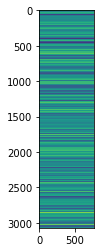

bert.encoder.layer.11.attention.output.dense.weight


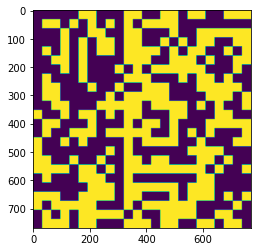

In [49]:
from matplotlib import pyplot as plt

parameters = dict(trainer.model.named_parameters())
param_names = ["bert.encoder.layer.11.intermediate.dense.weight",
               "bert.encoder.layer.11.attention.output.dense.weight"]

for param_name in param_names:          
    w = parameters[param_name]
    print(param_name)

    plt.imshow((w != 0).detach().cpu())
    plt.show()

In [50]:
from nn_pruning.inference_model_patcher import optimize_model

prunebert_model = optimize_model(trainer.model, "dense")

removed heads 0, total_heads=144, percentage removed=0.0
bert.encoder.layer.0.intermediate.dense, sparsity = 50.00
bert.encoder.layer.0.output.dense, sparsity = 50.00
bert.encoder.layer.1.intermediate.dense, sparsity = 50.00
bert.encoder.layer.1.output.dense, sparsity = 50.00
bert.encoder.layer.2.intermediate.dense, sparsity = 50.00
bert.encoder.layer.2.output.dense, sparsity = 50.00
bert.encoder.layer.3.intermediate.dense, sparsity = 50.00
bert.encoder.layer.3.output.dense, sparsity = 50.00
bert.encoder.layer.4.intermediate.dense, sparsity = 50.00
bert.encoder.layer.4.output.dense, sparsity = 50.00
bert.encoder.layer.5.intermediate.dense, sparsity = 50.00
bert.encoder.layer.5.output.dense, sparsity = 50.00
bert.encoder.layer.6.intermediate.dense, sparsity = 50.00
bert.encoder.layer.6.output.dense, sparsity = 50.00
bert.encoder.layer.7.intermediate.dense, sparsity = 50.00
bert.encoder.layer.7.output.dense, sparsity = 50.00
bert.encoder.layer.8.intermediate.dense, sparsity = 50.00
bert.

In [52]:
prunebert_model.num_parameters() / model.num_parameters()


0.8407130105742668

In [53]:
print_size_of_model(prunebert_model)
print_size_of_model(model)

Size (MB): 598.183021
Size (MB): 711.502957


In [ ]:
prunebert_model.to(device);

In [68]:
predicted_labels = []
true_labels = []
for sample in test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = prunebert_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  predicted_labels.append(logits.argmax().item())
  true_labels.append(true_label.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


## Inference time on CPU/GPU

In [70]:
# GPU Inference time.
%%timeit
c=0
for sample in test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0)
  attention_mask = sample['attention_mask'].unsqueeze(0)
  token_type_ids = sample['token_type_ids'].unsqueeze(0)
  logits = prunebert_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


10.3 s ± 1.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
prunebert_model.to('cpu')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [72]:
# CPU Inference time.
%%timeit

c_cpu=0
for sample in test_dataset:
  true_label = sample['labels']
  input_ids = sample['input_ids'].unsqueeze(0).to('cpu')
  attention_mask = sample['attention_mask'].unsqueeze(0).to('cpu')
  token_type_ids = sample['token_type_ids'].unsqueeze(0).to('cpu')
  logits = prunebert_model(input_ids=input_ids, attention_mask=attention_mask, 
                 token_type_ids=token_type_ids).logits
  c_cpu+=1
  if c_cpu % 100 == 0:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


1min 54s ± 2.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
# true_positive = sum([1 if pred == true_label else 0 for pred, true_label in zip(predicted_labels, true_labels)])
# accuracy = true_positive/len(true_labels)
test_score = f1_score(true_labels, predicted_labels)
print(f'f1_score: {test_score}')
print(f'Inference time on GPU: {10.3/len(test_dataset)} seconds')
print(f'Inference time on CPU: {115/100} seconds')

f1_score: 0.9759036144578314
Inference time on GPU: 0.02942857142857143 seconds
Inference time on CPU: 1.15 seconds
